Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MAISI Inference Tutorial

This tutorial illustrates how to use trained NV-Generate-CTMR model and codebase to generate synthetic 3D images and paired masks.

## Setup environment

In [1]:
!python -c "import monai" || python -m pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || python -m pip install -q matplotlib
!python -c "import skimage" || python -m pip install -U scikit-image
!python -c "import einops" || python -m pip install -U einops
%matplotlib inline

## Setup imports

In [2]:
import argparse
import json
import os
import tempfile

import monai
import torch
from monai.apps import download_url
from monai.config import print_config
from monai.transforms import LoadImage, Orientation
from monai.utils import set_determinism
from scripts.sample import LDMSampler, check_input_ct
from scripts.utils import define_instance
from scripts.utils_plot import find_label_center_loc, get_xyz_plot, show_image
from scripts.diff_model_setting import setup_logging
from scripts.download_model_data import download_model_data

print_config()

logger = setup_logging("notebook")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "max_split_size_mb:128,expandable_segments:True")

MONAI version: 1.5.1+4.g69f3dd26
Numpy version: 2.2.6
Pytorch version: 2.9.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 69f3dd26ed2a65e89ae89d951bb16f2dcb4d7c5d
MONAI __file__: /localhome/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 12.0.0
Tensorboard version: 2.20.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.24.0+cu128
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOW

## Set up the MAISI version

Choose among `'ddpm-ct'` and `'rflow-ct'`. The differences are:
- The version `'ddpm-ct'` uses basic noise scheduler DDPM. `'rflow-ct'` uses Rectified Flow scheduler, can be 33 times faster during inference.
- The version `'ddpm-ct'` requires training images to be labeled with body region (`"top_region_index"` and `"bottom_region_index"`), while `'rflow-ct'` does not have such requirement. In other words, it is easier to prepare training data.
- For the released model weights, `'rflow-ct'` can generate images with better quality for head region and small output volumes, and comparable quality for other cases compared with `'ddpm-ct'`.

In [3]:
generate_version = "rflow-ct"
if generate_version == "ddpm-ct":
    model_def_path = "./configs/config_network_ddpm.json"
elif generate_version == "rflow-ct":
    model_def_path = "./configs/config_network_rflow.json"
else:
    raise ValueError(f"generate_version has to be chosen from ['ddpm-ct', 'rflow-ct'], yet got {generate_version}.")
with open(model_def_path, "r") as f:
    model_def = json.load(f)
include_body_region = model_def["include_body_region"]
logger.info(f"Models are {generate_version}, whether to use body_region is {include_body_region}")

[2025-10-23 23:14:28.317][ INFO](notebook) - Models are rflow-ct, whether to use body_region is False


## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [4]:
os.environ["MONAI_DATA_DIRECTORY"] = "./temp_work_dir"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

download_model_data(generate_version,root_dir)

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'models/autoencoder_v1.pt' to 'temp_work_dir/.cache/huggingface/download/models/VWo8AZt44OCpaSakEZP-VW_OfWo=.1f8a7a056d0ebc00486edc43c26768bf1c12eaa6df9dd172e34598003be95eb3.incomplete'
Download complete. Moving file to temp_work_dir/models/autoencoder_v1.pt
Fetching 1 files: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['models/autoencoder_v1.pt']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'models/mask_generation_autoencoder.pt' to 'temp_work_dir/.cache/huggingface/download/models/2di160zr8mXBkHTWiAXJdeRAoYI=.539175f6ede3cb1e6f01bfd6347cd446d601cf4a508fc632a1e36362b1428a5d.incomplete'
Download complete. Moving file to temp_work_dir/models/mask_generation_autoencoder.pt
Fetching 1 files: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['models/mask_generation_autoencoder.pt']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'models/mask_generation_diffusion_unet.pt' to 'temp_work_dir/.cache/huggingface/download/models/AU7ko8wADtEaWwIZzRmkon7zads=.b7d668b1356e9b94b8269decadf8f8116dc4ee2d365580d05349b4ddf6739155.incomplete'
Download complete. Moving file to temp_work_dir/models/mask_generation_diffusion_unet.pt
Fetching 1 files: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['models/mask_generation_diffusion_unet.pt']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'datasets/all_anatomy_size_conditions.json' to 'temp_work_dir/.cache/huggingface/download/datasets/WpMTaVeHfRovSoz4eu6AEpImSi4=.7147004d5b45e9a580c303fb18cbb22a9656c668.incomplete'
Download complete. Moving file to temp_work_dir/datasets/all_anatomy_size_conditions.json
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['temp_work_dir/datasets/all_anatomy_size_conditions.json']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'datasets/all_masks_flexible_size_and_spacing_4000.zip' to 'temp_work_dir/.cache/huggingface/download/datasets/ldEgKbIJZa0_0jc5piX7wMTEgSo=.ce59e0e7e232c13bfc53c403df0ad22afc711d8e0601750b0a4a8e4d0f648ace.incomplete'
Download complete. Moving file to temp_work_dir/datasets/all_masks_flexible_size_and_spacing_4000.zip
Fetching 1 files: 100%|██████████| 1/1 [00:10<00:00, 10.40s/it]


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['temp_work_dir/datasets/all_masks_flexible_size_and_spacing_4000.zip']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'models/diff_unet_3d_rflow-ct.pt' to 'temp_work_dir/.cache/huggingface/download/models/j3NGkkdaq8XzOTQ3KSsNXV0_k-k=.cfc1ec59782f5ac7c0d22dd501654732109a971b93cbaa6607c4106a7f29066f.incomplete'
Download complete. Moving file to temp_work_dir/models/diff_unet_3d_rflow-ct.pt
Fetching 1 files: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['models/diff_unet_3d_rflow-ct.pt']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'models/controlnet_3d_rflow-ct.pt' to 'temp_work_dir/.cache/huggingface/download/models/PDEABfLPG81glWQqFwx__xx_ZMM=.2f16d7a6b4d6a22d5ba9278e59fd51f9a17a45244f0f256946c34a762cc12914.incomplete'
Download complete. Moving file to temp_work_dir/models/controlnet_3d_rflow-ct.pt
Fetching 1 files: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['models/controlnet_3d_rflow-ct.pt']
⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]Downloading 'datasets/candidate_masks_flexible_size_and_spacing_4000.json' to 'temp_work_dir/.cache/huggingface/download/datasets/WeieKTN4o3hQqTYaqbRPC1Jc5Qk=.4f3f1b59aac041c962b202bcf3d2e4b5729a1a66.incomplete'


/mnt/drive/canz/code/NV-Generate-CTMR/temp_work_dir
saved to: ['temp_work_dir/datasets/candidate_masks_flexible_size_and_spacing_4000.json']


Download complete. Moving file to temp_work_dir/datasets/candidate_masks_flexible_size_and_spacing_4000.json
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


## Read in environment setting, including data directory, model directory, and output directory

The information for data directory, model directory, and output directory are saved in ./configs/environment.json

In [5]:
args = argparse.Namespace()

if generate_version == "ddpm-ct":
    environment_file = "./configs/environment_ddpm-ct.json"
elif generate_version == "rflow-ct":
    environment_file = "./configs/environment_rflow-ct.json"
else:
    raise ValueError(f"generate_version has to be chosen from ['ddpm-ct', 'rflow-ct'], yet got {generate_version}.")

with open(environment_file, "r") as f:
    env_dict = json.load(f)
for k, v in env_dict.items():
    # Update the path to the downloaded dataset in MONAI_DATA_DIRECTORY
    val = v if "datasets/" not in v else os.path.join(root_dir, v)
    setattr(args, k, val)
    logger.info(f"{k}: {val}")
logger.info("Global config variables have been loaded.")

[2025-10-23 23:14:54.082][ INFO](notebook) - output_dir: output
[2025-10-23 23:14:54.083][ INFO](notebook) - trained_autoencoder_path: models/autoencoder_v1.pt
[2025-10-23 23:14:54.084][ INFO](notebook) - trained_diffusion_path: models/diff_unet_3d_rflow-ct.pt
[2025-10-23 23:14:54.085][ INFO](notebook) - trained_controlnet_path: models/controlnet_3d_rflow-ct.pt
[2025-10-23 23:14:54.086][ INFO](notebook) - trained_mask_generation_autoencoder_path: models/mask_generation_autoencoder.pt
[2025-10-23 23:14:54.087][ INFO](notebook) - trained_mask_generation_diffusion_path: models/mask_generation_diffusion_unet.pt
[2025-10-23 23:14:54.087][ INFO](notebook) - all_mask_files_base_dir: ./temp_work_dir/datasets/all_masks_flexible_size_and_spacing_4000
[2025-10-23 23:14:54.088][ INFO](notebook) - all_mask_files_json: ./temp_work_dir/datasets/candidate_masks_flexible_size_and_spacing_4000.json
[2025-10-23 23:14:54.089][ INFO](notebook) - all_anatomy_size_conditions_json: ./temp_work_dir/datasets/al

## Read in configuration setting, including network definition, body region and anatomy to generate, etc.

The information for the inference input, like body region and anatomy to generate, is stored in "./configs/config_infer.json". Please refer to README.md for the details.

In [6]:
with open(model_def_path, "r") as f:
    model_def = json.load(f)
for k, v in model_def.items():
    setattr(args, k, v)

# check the format of inference inputs
config_infer_file = "./configs/config_infer.json"
with open(config_infer_file, "r") as f:
    config_infer_dict = json.load(f)
for k, v in config_infer_dict.items():
    setattr(args, k, v)
    logger.info(f"{k}: {v}")
if generate_version == "ddpm-ct":
    args.num_inference_steps = 1000
    logger.warning(f"For DDPM, num_inference_steps must be: {args.num_inference_steps}. And it has been changed to {args.num_inference_steps}.")

if generate_version == "ddpm-ct" or generate_version == "rflow-ct":
    check_input_ct(
        args.body_region,
        args.anatomy_list,
        args.label_dict_json,
        args.output_size,
        args.spacing,
        args.controllable_anatomy_size,
    )
latent_shape = [args.latent_channels, args.output_size[0] // 4, args.output_size[1] // 4, args.output_size[2] // 4]
logger.info("Network definition and inference inputs have been loaded.")

[2025-10-23 23:14:54.102][ INFO](notebook) - num_output_samples: 1
[2025-10-23 23:14:54.103][ INFO](notebook) - body_region: ['chest']
[2025-10-23 23:14:54.104][ INFO](notebook) - anatomy_list: ['lung tumor']
[2025-10-23 23:14:54.104][ INFO](notebook) - controllable_anatomy_size: []
[2025-10-23 23:14:54.105][ INFO](notebook) - num_inference_steps: 30
[2025-10-23 23:14:54.106][ INFO](notebook) - mask_generation_num_inference_steps: 1000
[2025-10-23 23:14:54.106][ INFO](notebook) - output_size: [256, 256, 256]
[2025-10-23 23:14:54.107][ INFO](notebook) - image_output_ext: .nii.gz
[2025-10-23 23:14:54.107][ INFO](notebook) - label_output_ext: .nii.gz
[2025-10-23 23:14:54.108][ INFO](notebook) - spacing: [1.5, 1.5, 2.0]
[2025-10-23 23:14:54.109][ INFO](notebook) - autoencoder_sliding_window_infer_size: [48, 48, 48]
[2025-10-23 23:14:54.109][ INFO](notebook) - autoencoder_sliding_window_infer_overlap: 0.6666
[2025-10-23 23:14:54.110][ INFO](notebook) - controlnet: $@controlnet_def
[2025-10-

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)
args.random_seed = 0

## Initialize networks and noise scheduler, then load the trained model weights.

The networks and noise scheduler are defined in `config_maisi.json`. We will read them in and load the model weights.

In [8]:
noise_scheduler = define_instance(args, "noise_scheduler")
mask_generation_noise_scheduler = define_instance(args, "mask_generation_noise_scheduler")

device = torch.device("cuda")

autoencoder = define_instance(args, "autoencoder_def").to(device)
checkpoint_autoencoder = torch.load(args.trained_autoencoder_path)
if "unet_state_dict" in checkpoint_autoencoder.keys():
    checkpoint_autoencoder = checkpoint_autoencoder["unet_state_dict"]
autoencoder.load_state_dict(checkpoint_autoencoder)

diffusion_unet = define_instance(args, "diffusion_unet_def").to(device)
checkpoint_diffusion_unet = torch.load(args.trained_diffusion_path, weights_only=False)
diffusion_unet.load_state_dict(checkpoint_diffusion_unet["unet_state_dict"], strict=False)
scale_factor = checkpoint_diffusion_unet["scale_factor"].to(device)

controlnet = define_instance(args, "controlnet_def").to(device)
checkpoint_controlnet = torch.load(args.trained_controlnet_path, weights_only=False)
monai.networks.utils.copy_model_state(controlnet, diffusion_unet.state_dict())
controlnet.load_state_dict(checkpoint_controlnet["controlnet_state_dict"], strict=False)

mask_generation_autoencoder = define_instance(args, "mask_generation_autoencoder_def").to(device)
checkpoint_mask_generation_autoencoder = torch.load(args.trained_mask_generation_autoencoder_path, weights_only=True)
mask_generation_autoencoder.load_state_dict(checkpoint_mask_generation_autoencoder)

mask_generation_diffusion_unet = define_instance(args, "mask_generation_diffusion_def").to(device)
checkpoint_mask_generation_diffusion_unet = torch.load(args.trained_mask_generation_diffusion_path, weights_only=True)
mask_generation_diffusion_unet.load_state_dict(checkpoint_mask_generation_diffusion_unet["unet_state_dict"])
mask_generation_scale_factor = checkpoint_mask_generation_diffusion_unet["scale_factor"]

logger.info("All the trained model weights have been loaded.")

2025-10-23 23:15:03,812 - INFO - 'dst' model updated: 180 of 231 variables.


[2025-10-23 23:15:08.415][ INFO](notebook) - All the trained model weights have been loaded.


## Define the LDM Sampler, which contains functions that will perform the inference.

In [9]:
ldm_sampler = LDMSampler(
    args.body_region,
    args.anatomy_list,
    args.all_mask_files_json,
    args.all_anatomy_size_conditions_json,
    args.all_mask_files_base_dir,
    args.label_dict_json,
    args.label_dict_remap_json,
    autoencoder,
    diffusion_unet,
    controlnet,
    noise_scheduler,
    scale_factor,
    mask_generation_autoencoder,
    mask_generation_diffusion_unet,
    mask_generation_scale_factor,
    mask_generation_noise_scheduler,
    device,
    latent_shape,
    args.mask_generation_latent_shape,
    args.output_size,
    args.output_dir,
    args.controllable_anatomy_size,
    image_output_ext=args.image_output_ext,
    label_output_ext=args.label_output_ext,
    spacing=args.spacing,
    modality=args.modality,
    num_inference_steps=args.num_inference_steps,
    mask_generation_num_inference_steps=args.mask_generation_num_inference_steps,
    random_seed=args.random_seed,
    autoencoder_sliding_window_infer_size=args.autoencoder_sliding_window_infer_size,
    autoencoder_sliding_window_infer_overlap=args.autoencoder_sliding_window_infer_overlap,
    cfg_guidance_scale = args.cfg_guidance_scale
)

/localhome/local-pengfeig/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)
[2025-10-23 23:15:08.450][ INFO](root) - LDM sampler initialized.


## Perform the inference

In [10]:
logger.info(f"The generated image/mask pairs will be saved in {args.output_dir}.")
output_filenames = ldm_sampler.sample_multiple_images(args.num_output_samples)
logger.info("MAISI image/mask generation finished")

[2025-10-23 23:15:08.456][ INFO](notebook) - The generated image/mask pairs will be saved in output.


Extracting ./temp_work_dir/datasets/all_masks_flexible_size_and_spacing_4000.zip to ./temp_work_dir/datasets
2025-10-23 23:15:08,458 - INFO - Writing into directory: ./temp_work_dir/datasets.


[2025-10-23 23:16:51.971][ INFO](root) - Resample mask file to get desired output size and spacing


Unzipped ./temp_work_dir/datasets/all_masks_flexible_size_and_spacing_4000.zip to ./temp_work_dir/datasets/all_masks_flexible_size_and_spacing_4000.


[2025-10-23 23:16:54.585][ INFO](root) - Resampling mask to target shape and spacing
[2025-10-23 23:16:54.590][ INFO](root) - Resize Spacing: [tensor(0.7988, dtype=torch.float64), tensor(0.7988, dtype=torch.float64), tensor(1.1016, dtype=torch.float64)] -> [1.5, 1.5, 2.0]
[2025-10-23 23:16:54.591][ INFO](root) - Output size: [512, 512, 384] -> [256, 256, 256]
[2025-10-23 23:16:57.537][ INFO](root) - Resampling mask to target shape and spacing
[2025-10-23 23:16:57.540][ INFO](root) - Resize Spacing: [tensor(0.7031, dtype=torch.float64), tensor(0.7031, dtype=torch.float64), tensor(1.4795, dtype=torch.float64)] -> [1.5, 1.5, 2.0]
[2025-10-23 23:16:57.541][ INFO](root) - Output size: [512, 512, 256] -> [256, 256, 256]
[2025-10-23 23:17:00.310][ INFO](root) - Resampling mask to target shape and spacing
[2025-10-23 23:17:00.312][ INFO](root) - Resize Spacing: [tensor(0.7617, dtype=torch.float64), tensor(0.7617, dtype=torch.float64), tensor(1.2939, dtype=torch.float64)] -> [1.5, 1.5, 2.0]
[20

augmenting lung tumor
28
metatensor(180., device='cuda:0') | metatensor(547.4000, device='cuda:0')


[2025-10-23 23:17:21.112][ INFO](root) - ---- Mask preparation time: 11.41016936302185 seconds ----
[2025-10-23 23:17:21.155][ INFO](root) - ---- Start generating latent features... ----


metatensor(687., device='cuda:0') | metatensor(547.4000, device='cuda:0')


100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.63it/s]
[2025-10-23 23:17:32.711][ INFO](root) - ---- DM/ControlNet Latent features generation time: 11.556089162826538 seconds ----
[2025-10-23 23:17:33.026][ INFO](root) - ---- Start decoding latent features into images... ----
  0%|                                                     | 0/8 [00:00<?, ?it/s]/localhome/local-pengfeig/.local/lib/python3.10/site-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/localhome/local-pengfeig/.local/lib/python3.10/site-packages/monai/inferers/utils.py:370:

2025-10-23 23:18:09,527 INFO image_writer.py:197 - writing: output/sample_20251023_231809_503583_image.nii.gz
2025-10-23 23:18:11,168 INFO image_writer.py:197 - writing: output/sample_20251023_231809_503583_label.nii.gz


[2025-10-23 23:18:12.171][ INFO](notebook) - MAISI image/mask generation finished


## Visualize the results


[2025-10-23 23:18:12.192][ INFO](notebook) - Visualizing output/sample_20251023_231809_503583_image.nii.gz and output/sample_20251023_231809_503583_label.nii.gz...
/localhome/local-pengfeig/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.array Orientation.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


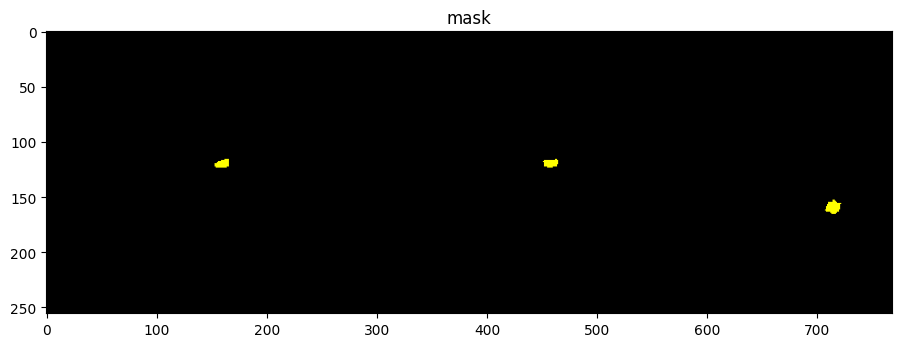

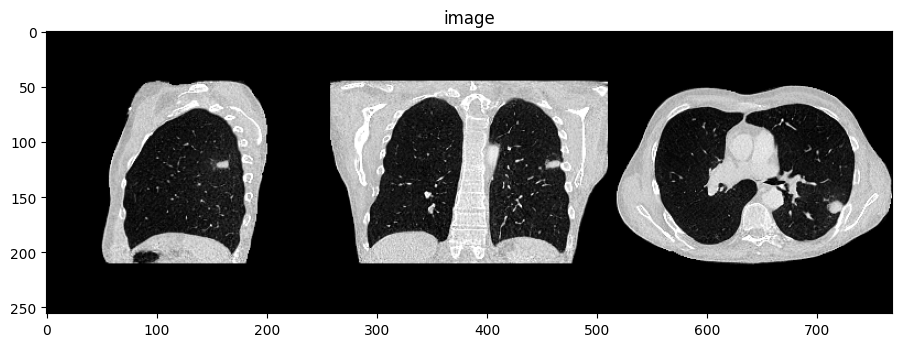

In [11]:
visualize_image_filename = output_filenames[0][0]
visualize_mask_filename = output_filenames[0][1]
logger.info(f"Visualizing {visualize_image_filename} and {visualize_mask_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
mask_volume = orientation(loader(visualize_mask_filename)).to(torch.uint8)

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))

# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")